In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

import nltk
from nltk.corpus import inaugural
from nltk.corpus import stopwords
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.extmath import density
from sklearn import metrics

import warnings
import random
warnings.filterwarnings("ignore")
nltk.download('inagural')
nltk.download('stopwords')

[nltk_data] Error loading inagural: Package 'inagural' not found in
[nltk_data]     index
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/davidsimbandumwe/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [21]:
random.seed(137)

# Load Data

In [22]:
#inaugural.fileids()

In [23]:
party = pd.read_csv('https://raw.githubusercontent.com/dsimband/DATA620_Group3/main/Week10_Assignment/presidents.csv',index_col=0)
len(party)

59

In [24]:
print('Sentences:',len(inaugural.sents()),'Words:',len(inaugural.words()))

Sentences: 5217 Words: 152901


In [25]:
text_data = pd.DataFrame(columns = ['filename','year','length','unique'])
stop_words = set(stopwords.words('english')) 
custom_stopwords = set((',',' ','.', ';', '?', '-', '!', '(', ')','--','"',"'", ':', '¡¦', '¡','', '9',
                        '/', '11','ii', '400','1863','','people','shall','may','country','government',
                        'world', 'nation', 'must', 'great','upon','america','new','one','states','peace',
                        'every','us',',"'))


for file in inaugural.fileids():
    
    word_list = inaugural.words(file)
    word_list = [w.lower() for w in word_list] 
    word_list = [word.lower() for word in word_list if word.lower() not in stop_words] 
    word_list = [word.lower() for word in word_list if word.lower() not in custom_stopwords]
    
    this_file = pd.DataFrame(data = {"filename":[file], \
                                     "president" : [str(file[5:])], \
                                     "year" : [int(file[:4])], \
                                     "length" : [len(word_list)], \
                                     "unique" : [len(set(word_list))], \
                                     "words" : ' '.join(word_list)})
    text_data = text_data.append(this_file, ignore_index=True)

In [26]:
len(text_data)

59

In [27]:
text_data['president'] = text_data['president'].str.replace('.txt','')
speech_df = pd.merge(text_data, party, on=['year','president'], how='left')
speech_df['id'] = speech_df.index
speech_df[-10:]

,filename,year,length,unique,president,words,party,id
49,1985-Reagan.txt,1985,1152,747,Reagan,senator mathias chief justice burger vice pres...,Republican,49
50,1989-Bush.txt,1989,987,625,Bush,mr chief justice mr president vice president q...,Republican,50
51,1993-Clinton.txt,1993,686,498,Clinton,fellow citizens today celebrate mystery americ...,Democrat,51
52,1997-Clinton.txt,1997,954,615,Clinton,fellow citizens last presidential inauguration...,Democrat,52
53,2001-Bush.txt,2001,704,487,Bush,president clinton distinguished guests fellow ...,Republican,53
54,2005-Bush.txt,2005,952,634,Bush,vice president cheney mr chief justice preside...,Republican,54
55,2009-Obama.txt,2009,1062,781,Obama,fellow citizens stand today humbled task grate...,Democrat,55
56,2013-Obama.txt,2013,930,672,Obama,thank thank much vice president biden mr chief...,Democrat,56
57,2017-Trump.txt,2017,626,444,Trump,chief justice roberts president carter preside...,Republican,57
58,2021-Biden.txt,2021,1067,647,Biden,chief justice roberts vice president harris sp...,Democrat,58


In [28]:
len(speech_df)

59

In [29]:
speech_df = speech_df[speech_df['year'] > 1900]

In [30]:
len(speech_df)

31

# Analyze word Choice

In [31]:
from wordcloud import WordCloud

def wordcloud_draw(data, color = 'white'):
    
    
    words = ' '.join(data)
 
    wordcloud = WordCloud(
                      background_color=color,
                      width=5000,
                      height=3000
                     ).generate(words)
    plt.figure(1,figsize=(10, 7))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

x = (speech_df.iloc[4].words).split()
wordcloud_draw(x)

In [32]:
set(speech_df['party'])

{'Democrat', 'Republican'}

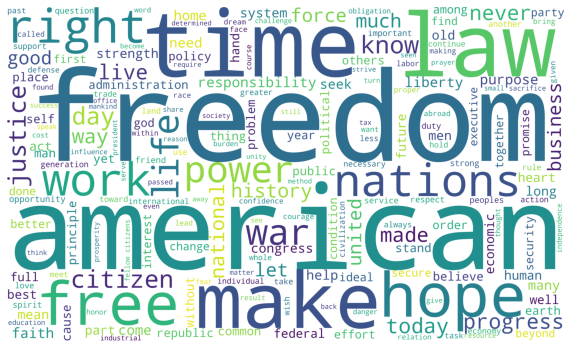

In [33]:
republic_df = speech_df[speech_df['party'] == 'Republican']
r = str(republic_df['words'].values)
r = r.split()
wordcloud_draw(r)

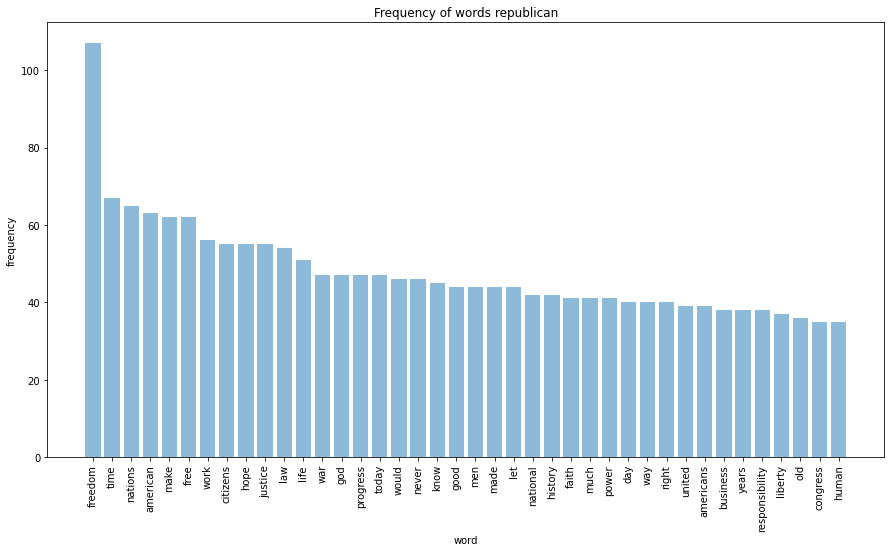

In [34]:
fdist1 = nltk.FreqDist(r)
r = fdist1.most_common(40) 

r_df = pd.DataFrame(r, columns=['word','freq'])

plt.figure(figsize=(15,8))
plt.bar(r_df['word'], r_df['freq'], align='center', alpha=0.5)
plt.xticks(rotation='vertical')
plt.ylabel('frequency')
plt.xlabel('word')
plt.title('Frequency of words republican')
plt.show()

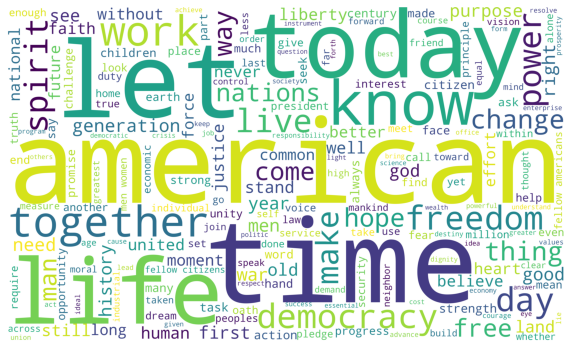

In [35]:
dems_df = speech_df[speech_df['party'] == 'Democrat']
d = str(dems_df['words'].values)
d = d.split()
wordcloud_draw(d)

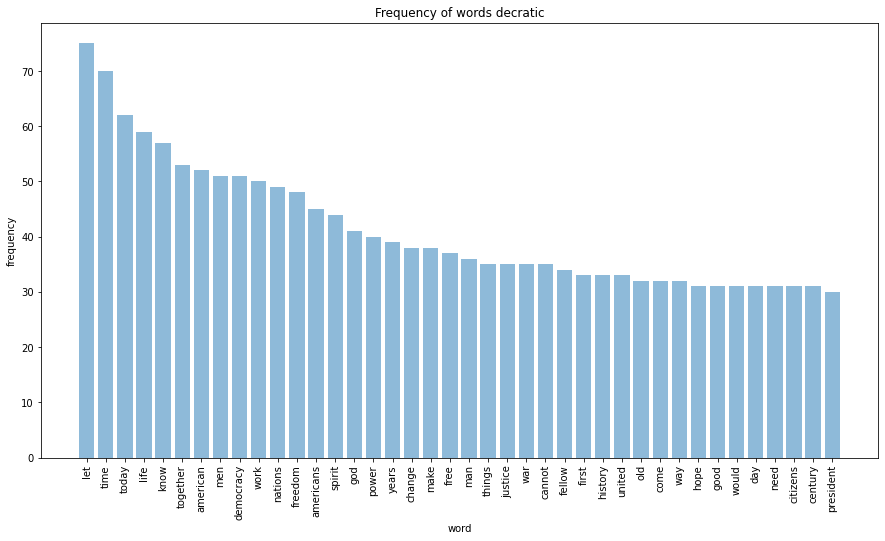

In [36]:
fdist1 = nltk.FreqDist(d)
d = fdist1.most_common(40) 

d_df = pd.DataFrame(d, columns=['word','freq'])

plt.figure(figsize=(15,8))
plt.bar(d_df['word'], d_df['freq'], align='center', alpha=0.5)
plt.xticks(rotation='vertical')
plt.ylabel('frequency')
plt.xlabel('word')
plt.title('Frequency of words decratic')
plt.show()

<br>

# Document Classification

In [61]:
vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5, stop_words="english")
bag = vectorizer.fit_transform(list(speech_df['words']))

In [62]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

X = bag.toarray()
y = np.array(list(speech_df['party']))

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=137)
print('size of train:',len(X_train))
print('size of test:',len(X_test))

size of train: 21
size of test: 10


<br>

## Logistic Regression Classifier

In [64]:
# Create an instance of LogisticRegression classifier
lr = LogisticRegression(C=100.0, random_state=1, solver='lbfgs', multi_class='ovr')

# Fit the model
lr.fit(X_train, y_train)

# Create the predictions
y_predict = lr.predict(X_test)
  
# Use metrics.accuracy_score to measure the score
print("LogisticRegression Accuracy %.3f" %metrics.accuracy_score(y_test, y_predict))
print(metrics.classification_report(y_test, y_predict))
print(metrics.confusion_matrix(y_test, y_predict))

LogisticRegression Accuracy 0.600
              precision    recall  f1-score   support

    Democrat       0.57      0.80      0.67         5
  Republican       0.67      0.40      0.50         5

    accuracy                           0.60        10
   macro avg       0.62      0.60      0.58        10
weighted avg       0.62      0.60      0.58        10

[[4 1]
 [3 2]]


<br>

## K Nearest Neighbors Classifier

In [65]:
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train, y_train)
y_predict = knn.predict(X_test)
score = metrics.accuracy_score(y_test, y_predict)
print("KNeighbors Accuracy %.3f" %metrics.accuracy_score(y_test, y_predict))
print(metrics.classification_report(y_test, y_predict))
print(metrics.confusion_matrix(y_test, y_predict))

KNeighbors Accuracy 0.500
              precision    recall  f1-score   support

    Democrat       0.50      0.60      0.55         5
  Republican       0.50      0.40      0.44         5

    accuracy                           0.50        10
   macro avg       0.50      0.50      0.49        10
weighted avg       0.50      0.50      0.49        10

[[3 2]
 [3 2]]


<br>

## Random Forest Classifier

In [66]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_predict = rf.predict(X_test)
score = metrics.accuracy_score(y_test, y_predict)
print("KNeighbors Accuracy %.3f" %metrics.accuracy_score(y_test, y_predict))
print(metrics.classification_report(y_test, y_predict))
print(metrics.confusion_matrix(y_test, y_predict))

KNeighbors Accuracy 0.700
              precision    recall  f1-score   support

    Democrat       0.62      1.00      0.77         5
  Republican       1.00      0.40      0.57         5

    accuracy                           0.70        10
   macro avg       0.81      0.70      0.67        10
weighted avg       0.81      0.70      0.67        10

[[5 0]
 [3 2]]
